# EnvNet for training

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="7" 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
class iter_len:
    def __init__(self,enumerator, l):
        self.enumerator = enumerator
        self.l = l
    def __next__(self):
        return self.enumerator.__next__()
    def __len__(self):
        return self.l
    def __iter__(self):
        return self.enumerator

def cudify_i(x):
    try:
        iter(x)
    except:
        return False
    for a in x:
        yield cudify(a)

def cudify(x):
    if isinstance(x, tuple):
        return (cudify(a) for a in x)
    if isinstance(x, list):
        return [cudify(a) for a in x]
    if isinstance(x, dict):
        return dict([(k, cudify(x[k])) for k in x])
    if isinstance(x, torch.Tensor):
        return x.cuda() if torch.cuda.is_available() else x
    if '__len__' in dir(x):
        return iter_len(cudify_i(x), x.__len__())

    as_i = cudify_i(x)
    if as_i == False:
        return x.cuda() if torch.cuda.is_available() else x
    return as_i

In [4]:
def weights_init(m):    
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.xavier_uniform_(m.weight.data)
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.fill_(1)
        m.bias.data.fill_(0)  
        
class ConvBNReLu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=False):
        super(ConvBNReLu, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, 
                      out_channels=out_channels, 
                      kernel_size=kernel_size, 
                      stride=stride, 
                      padding=padding,  
                      bias=bias),
            nn.BatchNorm2d(out_channels),
        )
    
    
    def forward(self, input):
        return self.main(input)


In [5]:
model = ConvBNReLu(100, 100, 3)
model.apply(weights_init)

ConvBNReLu(
  (main): Sequential(
    (0): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [6]:
torch.__version__

'0.4.0'

In [7]:
from torch.autograd import Variable

tensor = Variable(torch.rand([1, 100, 6, 6]))
model.forward(tensor)

tensor([[[[-1.2632, -1.6396,  0.2961,  1.7738],
          [-0.9024,  0.1462,  1.0970,  0.3774],
          [ 0.3606, -0.3944,  0.6443,  1.6921],
          [-1.3356,  0.4018, -0.6632, -0.5909]],

         [[ 0.2284, -0.4434,  1.4893,  2.4261],
          [-1.4432, -0.3355, -1.3687, -0.5803],
          [-1.2685,  0.1405,  1.0924,  0.2218],
          [-0.1572, -0.2498,  0.4781, -0.2301]],

         [[ 0.4191,  0.3441, -2.2128,  0.0719],
          [-0.3318, -1.6171, -0.1065, -0.3369],
          [ 1.8118,  0.3197,  0.4503, -0.1837],
          [ 0.0138,  1.8004, -0.9253,  0.4832]],

         ...,

         [[-1.5243, -0.8112, -0.0421, -1.3563],
          [ 0.2127,  0.2337,  0.5789, -1.4750],
          [-0.1644,  1.6018, -0.2757,  0.5853],
          [-0.8401,  0.2931,  1.8861,  1.0976]],

         [[-0.8622, -0.0586, -1.4894, -0.1043],
          [ 0.9553, -0.6641, -0.0092,  0.4378],
          [ 1.7472, -0.3784, -0.1873, -1.8069],
          [ 1.9949, -0.1030, -0.3880,  0.9163]],

         [[-0.2

In [8]:
"""
 Implementation of EnvNet [Tokozume and Harada, 2017]
 opt.fs = 16000
 opt.inputLength = 24014

# """

class Flatten(nn.Module):
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x

class EnvNet(nn.Module):
    def __init__(self, n_classes):
        super(EnvNet, self).__init__()
        self.conv1 = ConvBNReLu(1, 40, (1, 8))
        self.conv2 = ConvBNReLu(40, 40, (1, 8))        
        self.max_pool2 = nn.MaxPool2d((1, 160), ceil_mode=True)
        
        self.conv3 = ConvBNReLu(1, 50, (8, 13))
        self.max_pool3 = nn.MaxPool2d((3, 3), ceil_mode=True)
        
        self.conv4 = ConvBNReLu(50, 50, (1, 5))                
        self.max_pool4 = nn.MaxPool2d((1, 3), ceil_mode=True)        

        self.flatten = Flatten()
        
        self.fc5 = nn.Linear(in_features=50 * 11 * 14, out_features=4096, bias=True)
        self.relu5 = nn.ReLU()
        self.dropout5 = nn.Dropout()
        
        self.fc6 = nn.Linear(4096, 4096)
        self.relu6 = nn.ReLU()
        self.dropout6 = nn.Dropout()
        
        self.fc7 = nn.Linear(4096, n_classes)        
        self.out_l = nn.LogSoftmax()

    def forward(self, inp):
        out = self.conv1(inp)
        out = self.conv2(out)
        out = self.max_pool2(out)

        out = out.transpose(1, 2)
        
        out = self.conv3(out)          
        out = self.max_pool3(out)
        
        out = self.conv4(out)
        out = self.max_pool4(out)
        
        out = self.flatten(out)
        
        out = self.fc5(out)
        out = self.relu5(out)
        out = self.dropout5(out) 
        
        out = self.fc6(out)
        out = self.relu6(out)
        out = self.dropout6(out) 
        
        out = self.fc7(out)
        out = self.out_l(out)
        return out

In [9]:
import numpy as np
from torch.autograd import Variable

tensor = Variable(torch.rand([10, 1, 1, 24000]))
model = EnvNet(10)
model = model.apply(weights_init)
model.forward(tensor)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:63: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[-2.2975, -2.3384, -2.2597, -2.2463, -2.4085, -2.3060, -2.2881,
         -2.1146, -2.4686, -2.3394],
        [-2.0704, -2.5049, -2.1128, -2.2777, -2.1409, -2.3772, -2.4179,
         -2.6481, -2.3516, -2.2703],
        [-2.4781, -2.7704, -2.3249, -2.0822, -2.0619, -2.3736, -2.3409,
         -2.2924, -2.0738, -2.4341],
        [-2.3676, -2.4485, -2.2185, -2.3607, -2.0658, -2.5519, -1.9799,
         -2.4702, -2.3517, -2.3618],
        [-2.1765, -2.1931, -2.3313, -2.5033, -2.3298, -2.4208, -2.4413,
         -2.2900, -2.5082, -1.9653],
        [-2.1627, -2.2296, -2.4219, -2.2834, -2.1747, -2.4926, -2.2701,
         -2.3098, -2.5124, -2.2375],
        [-1.9517, -2.5077, -2.4865, -2.7600, -2.2273, -2.4316, -2.2878,
         -2.3934, -2.2265, -2.0129],
        [-2.3936, -2.8267, -2.2763, -2.2408, -1.9356, -2.3553, -2.2401,
         -2.2923, -2.3663, -2.3030],
        [-2.0237, -2.6266, -2.3552, -2.5637, -2.2796, -2.3568, -2.2881,
         -2.2951, -2.3196, -2.0710],
        [-2.2933, -

# Make PyTorch DataLoader

In [10]:
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import RandomResizedCrop, Pad, \
                                    RandomResizedCrop, RandomCrop, TenCrop, \
                                    ToTensor, ToPILImage, Lambda
from torch.utils import data

IMG = 'img'
LABEL = 'label'

#Do right reshape
class Centring(object):
    def __init__(self, factor):
        self.factor = factor

    def __call__(self, img):
        return img / self.factor
            
    
    
class convertToTuple(object):
    def __init__(self, transform):
        self.transform = transform
        
    def __call__(self, sample):
        img, label = sample[IMG], sample[LABEL]
        return {IMG: self.transform(img), 
                LABEL: label}

In [11]:
import torch
import warnings

import PIL
from PIL import Image

# disable decomression bomb
Image.MAX_IMAGE_PIXELS = None

T = 24000
MAX_INT = 32768.0

train_trans = transforms.Compose([convertToTuple(transform) for transform in [ToPILImage(),
                                                                             Pad((T//2, 0)),
                                                                             RandomCrop((1, T)),
                                                                             ToTensor(),
                                                                             Centring(MAX_INT)
                                                                                  ]])
tensor = {IMG: torch.randint(3, 10, [1, T, 1]), LABEL: 1}
result_tensor = train_trans(tensor)

test_trans = transforms.Compose([convertToTuple(transform) for transform in [ToPILImage(),       
                                                                            Pad((T//2, 0)),
                                                                            TenCrop((1, T)),
                                                                            Lambda(lambda crops: torch.stack([ToTensor()(crop) for crop in crops])),
                                                                            Centring(MAX_INT),  
                                                                              ]])

tensor = {IMG: torch.randint(3, 10, [1, T, 1]), LABEL: 1}
result_tensor = test_trans(tensor)
print(result_tensor[IMG].shape)

torch.Size([10, 1, 1, 24000])


In [12]:
import torch 

def make_one_hot(labels, C=2):
    '''
    Converts an integer label torch.autograd.Variable to a one-hot Variable.
    
    Parameters
    ----------
    labels : torch.autograd.Variable of torch.cuda.LongTensor
        N x 1 x H x W, where N is batch size. 
        Each value is an integer representing correct classification.
    C : integer. 
        number of classes in labels.
    
    Returns
    -------
    target : torch.autograd.Variable of torch.cuda.FloatTensor
        N x C x H x W, where C is class number. One-hot encoded.
    '''
    one_hot = FloatTensor(labels.size(0), C, labels.size(2), labels.size(3)).zero_()
    target = one_hot.scatter_(1, labels.data, 1)
    
    target = Variable(target)
        
    return cudify(target)

def numpy_one_hot(label, C=2):
    label = np.eye(C)[label]
    return label

def tensor_to_numpy(X):
    if torch.cuda.is_available():
        return X.cpu().numpy()
    else:
        return X.numpy()

In [13]:
# For BC learning
def a_weight(fs, n_fft, min_db=-80.0):
    freq = np.linspace(0, fs // 2, n_fft // 2 + 1)
    freq_sq = np.power(freq, 2)
    freq_sq[0] = 1.0
    weight = 2.0 + 20.0 * (2 * np.log10(12194) + 2 * np.log10(freq_sq)
                           - np.log10(freq_sq + 12194 ** 2)
                           - np.log10(freq_sq + 20.6 ** 2)
                           - 0.5 * np.log10(freq_sq + 107.7 ** 2)
                           - 0.5 * np.log10(freq_sq + 737.9 ** 2))
    weight = np.maximum(weight, min_db)

    return weight

def compute_gain(sound, fs, min_db=-80.0, mode='A_weighting'):
    if fs == 16000:
        n_fft = 2048
    elif fs == 44100:
        n_fft = 4096
    else:
        raise Exception('Invalid fs {}'.format(fs))
    stride = n_fft // 2

    gain = []
    for i in range(0, len(sound) - n_fft + 1, stride):
        if mode == 'RMSE':
            g = np.mean(sound[i: i + n_fft] ** 2)
        elif mode == 'A_weighting':
            spec = np.fft.rfft(np.hanning(n_fft + 1)[:-1] * sound[i: i + n_fft])
            power_spec = np.abs(spec) ** 2
            a_weighted_spec = power_spec * np.power(10, a_weight(fs, n_fft) / 10)
            g = np.sum(a_weighted_spec)
        else:
            raise Exception('Invalid mode {}'.format(mode))
        gain.append(g)

    gain = np.array(gain)
    gain = np.maximum(gain, np.power(10, min_db / 10))
    gain_db = 10 * np.log10(gain)

    return gain_db


def mix(sound1, sound2, r, fs):
    gain1 = np.max(compute_gain(sound1, fs))  # Decibel
    gain2 = np.max(compute_gain(sound2, fs))    
    
    t = 1.0 / (1 + np.power(10, (gain1 - gain2) / 20.) * (1 - r) / r)
    sound = ((sound1 * t + sound2 * (1 - t)) / np.sqrt(t ** 2 + (1 - t) ** 2))

    return sound

In [14]:
import os
import numpy as np

from torch.utils import data

DEFAULT_TRANSFORM = transforms.Compose([convertToTuple(transform) for transform in [ToPILImage(),       
                                                                                    Pad((T//2, 0)),
                                                                                    TenCrop((1, T)),
                                                                                    Lambda(lambda crops: torch.stack([ToTensor()(crop) for crop in crops])),
                                                                                    Centring(MAX_INT),  
                                                                                      ]])
class BCDatasets(data.Dataset):
    def __init__(self, data_path, dataset_name, 
                 sr, exclude, transform=DEFAULT_TRANSFORM,
                 mix=False, precision=np.float32):
        self.transform = transform
        self.sr = sr
        self.mix = mix
        self.precision = precision
        dataset = np.load(os.path.join(data_path, dataset_name, 'wav{}.npz'.format(sr // 1000)))
        
        self.X = []
        self.y = []
        for fold_name in dataset.keys():
            if int(fold_name[4:]) in exclude:
                continue
            
            sounds = dataset[fold_name].item()['sounds']
            labels = dataset[fold_name].item()['labels']
            
            self.X.extend(sounds)
            self.y.extend(labels)
            
        self.n_classes = len(set(self.y))
    
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.y)
    
    def __do_transform(self, x, y):
        y = numpy_one_hot(y, C = self.n_classes)
        

        x = x.astype(self.precision)
        sample = {IMG: x, LABEL: y}
        if self.transform:
            sample[IMG] = sample[IMG].reshape((1, -1, 1))
            sample = self.transform(sample)            
            sample[IMG] = tensor_to_numpy(sample[IMG])
            
        return sample
    
    def __mix_samples(self, sample1, sample2):
        r = np.random.uniform()
        
        sound1 = sample1[IMG].reshape((-1))
        sound2 = sample2[IMG].reshape((-1))
        
        sound = mix(sound1, sound2, r, self.sr)
        label = r * sample1[LABEL] + (1.0 - r) * sample2[LABEL]
        
        return {IMG: sound, LABEL: label}

    def __getitem__(self, index):
        'Generates one sample of data'
        sample = None
        if self.mix:
            idx1, idx2 = np.random.choice(len(self), 2, replace=False)
            
            sound1, label1 = self.X[idx1], self.y[idx1]
            sound2, label2 = self.X[idx2], self.y[idx2]
            
            sample1 = self.__do_transform(sound1, label1)
            sample2 = self.__do_transform(sound2, label2)
            
            sample = self.__mix_samples(sample1, sample2)
        else:
            x = self.X[index]
            y = self.y[index]
            
            sample = self.__do_transform(self.X[index], self.y[index])
            
        sample[IMG] = sample[IMG].reshape((1, 1, -1))
            
        return sample

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

DataLoader len: 320
{'label': array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), 'img': array([[[ 0.        ,  0.        ,  0.        , ..., -0.0524292 ,
         -0.10327148, -0.14562988]]], dtype=float32)}
X shape: (1, 1, 24000)
y: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
<class 'numpy.ndarray'>
True


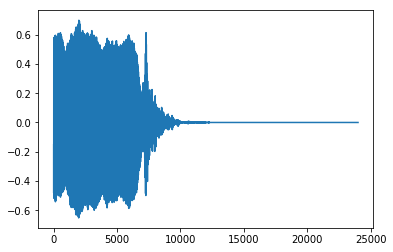

In [16]:
import numpy as np

data_path = "/raid/data/lmarkeeva/datasets"
dataset_name = "esc10"
sample_rate = 16000
exclude = set([1])

data_loader = BCDatasets(data_path, dataset_name, sample_rate, exclude, transform=train_trans)
print("DataLoader len:", len(data_loader))

result = data_loader[100]
print(data_loader[100])

print("X shape:", result[IMG].shape)
print("y:", result[LABEL])
print(result[IMG].__class__)
print(torch.cuda.is_available())

plt.plot(result[IMG][0, 0, :])
plt.show()

DataLoader len: 320
{'label': array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), 'img': array([[[0.06091121, 0.13108838, 0.03007501, ..., 0.22674567,
         0.22780354, 0.24239373]]], dtype=float32)}
X shape: (1, 1, 24000)
y: [0.         0.         0.         0.         0.07649003 0.
 0.92350997 0.         0.         0.        ]
<class 'numpy.ndarray'>
True


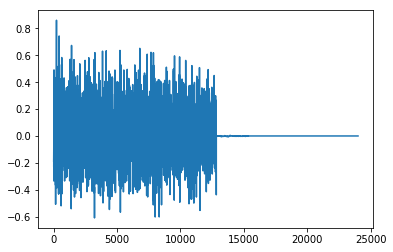

In [17]:
data_path = "/raid/data/lmarkeeva/datasets"
dataset_name = "esc10"
sample_rate = 16000
exclude = set([1])

data_loader = BCDatasets(data_path, dataset_name, sample_rate, exclude, transform=train_trans, mix=True)
print("DataLoader len:", len(data_loader))

result = data_loader[100]
print(data_loader[100])

print("X shape:", result[IMG].shape)
print("y:", result[LABEL])
print(result[IMG].__class__)
print(torch.cuda.is_available())

plt.plot(result[IMG][0, 0, :])
plt.show()

In [18]:
import torch
from torch.utils import data

data_path = "/raid/data/lmarkeeva/datasets"
dataset_name = "esc10"
sample_rate = 16000
exclude_train = set([1])
exclude_val = set([2, 3, 4, 5])

params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 1,
        }

train_set = BCDatasets(data_path, dataset_name, sample_rate, exclude_train, transform=train_trans)
val_set = BCDatasets(data_path, dataset_name, sample_rate, exclude_val, transform=test_trans)

training_generator = data.DataLoader(train_set, **params)
validation_generator = data.DataLoader(val_set, **params)

In [19]:
transformed_dataset = BCDatasets(data_path, dataset_name, sample_rate, exclude_train, transform=train_trans, mix=True)

PRINT_FIRST = 1
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample[IMG].shape, sample[LABEL].reshape((-1)))

    if i == PRINT_FIRST:
        break

0 (1, 1, 24000) [0.         0.         0.60000942 0.         0.39999058 0.
 0.         0.         0.         0.        ]
1 (1, 1, 24000) [0.         0.         0.         0.         0.         0.
 0.         0.51357029 0.48642971 0.        ]


In [20]:
batch_size = 4
dataloader = data.DataLoader(transformed_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

0 torch.Size([4, 1, 1, 24000]) torch.Size([4, 10])
[[0.         0.         0.99332369 0.00667631 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.84015854 0.         0.         0.15984146 0.
  0.         0.         0.         0.        ]
 [0.29243346 0.         0.70756654 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.22519113
  0.77480887 0.         0.         0.        ]]


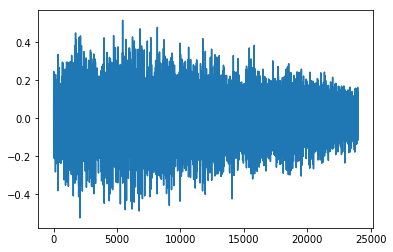

[[0.         0.         0.99332369 0.00667631 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.84015854 0.         0.         0.15984146 0.
  0.         0.         0.         0.        ]
 [0.29243346 0.         0.70756654 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.22519113
  0.77480887 0.         0.         0.        ]]


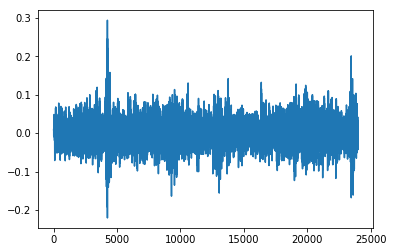

[[0.         0.         0.99332369 0.00667631 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.84015854 0.         0.         0.15984146 0.
  0.         0.         0.         0.        ]
 [0.29243346 0.         0.70756654 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.22519113
  0.77480887 0.         0.         0.        ]]


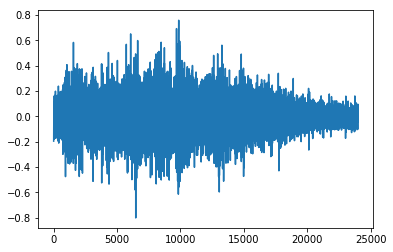

[[0.         0.         0.99332369 0.00667631 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.84015854 0.         0.         0.15984146 0.
  0.         0.         0.         0.        ]
 [0.29243346 0.         0.70756654 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.22519113
  0.77480887 0.         0.         0.        ]]


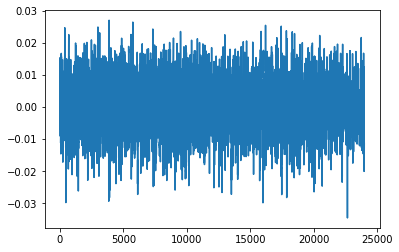

In [21]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched[IMG].size(),
          sample_batched[LABEL].size())
    for i in range(batch_size):
        print(tensor_to_numpy(sample_batched[LABEL]))
        plt.plot(tensor_to_numpy(sample_batched[IMG])[i, 0, 0, :])
        plt.show()
    break

# Okay, let's make training procedure

In [22]:
import torch 

def tensor_to_numpy(X):
    if torch.cuda.is_available():
        return X.cpu().numpy()
    else:
        return X.numpy()

if torch.cuda.is_available():
    FloatTensor = torch.cuda.FloatTensor
    LongTensor = torch.cuda.LongTensor
    ByteTensor = torch.cuda.ByteTensor
else:
    DoubleTensor = torch.DoubleTensor
    FloatTensor = torch.FloatTensor
    LongTensor = torch.LongTensor
    ByteTensor = torch.ByteTensor

In [23]:
import time

from torch.nn.modules.loss import KLDivLoss
from torch.optim import SGD
from torch.optim.lr_scheduler import MultiStepLR

from IPython import display
import ipdb

def draw_progress(train_loss, val_loss, train_error_rate, test_error_rate, num_epochs, curr_epoch, cv):
    display.clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(train_loss, "r", label='Train loss')
    plt.plot(val_loss, "g", label='Val loss')
    plt.title("CV: {}, Epoch {}".format(cv, curr_epoch))
    plt.xlabel("epoch")
    plt.ylabel("KL div")
    plt.xlim(0, len(train_loss))
    plt.legend()
    plt.grid()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_error_rate, "r", label='Train error_rate')
    plt.plot(test_error_rate, "g", label='Test error_rate')  
    plt.title("CV: {}, Epoch {}".format(cv, curr_epoch))
    plt.xlabel("epoch")
    plt.ylabel("error rate")
    plt.legend()
    plt.grid()    
    plt.show() 
    
def accuracy(output, target):
    with torch.no_grad():
        maxk = 1
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        
        result = torch.mean(correct.view(-1).float())
        return result

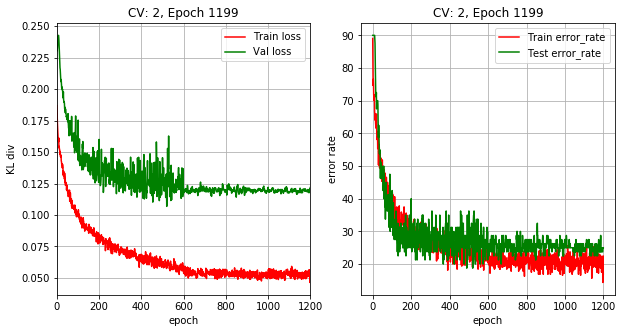

In [25]:
global_train_loss = []
global_val_loss = []
global_train_error = []
global_val_error = []
n_folds = 5
num_classes = 10

mix_up = True

# for test_fold in range(1, n_folds + 1):
for test_fold in range(2, 3):
    model = EnvNet(10)
    if torch.cuda.is_available():
        print("we will use cuda model!")
        model = model.cuda()
    model.apply(weights_init)


    BC = False
    opt_params = {"weight_decay": 0.0005, 
                  "momentum": 0.9,
                  "nesterov": True,
                  "lr": 0.01,
                 }
    epochs = 600 if not mix_up else 1200
    epochs = 2 * epochs if BC else epochs
    optimizer = SGD(model.parameters(), **opt_params)
    scheduler = MultiStepLR(optimizer, milestones=[int(0.5 * epochs), int(0.75 * epochs)], gamma=0.1)

    data_path = "/raid/data/lmarkeeva/datasets"
    dataset_name = "esc10"
    sample_rate = 16000

    kl_loss = KLDivLoss()
   
    train_loss = []
    train_error_rate = []
    val_loss = []
    val_error_rate = []
    
    folds = set(range(1, n_folds + 1))
    exclude_train = set([test_fold])
    exclude_val = folds - exclude_train

    for epoch in range(epochs):
        scheduler.step()
        train_set = BCDatasets(data_path, dataset_name, sample_rate, exclude_train, transform=train_trans, mix=mix_up)
        val_set = BCDatasets(data_path, dataset_name, sample_rate, exclude_val, transform=test_trans)

        train_batch_size = 64
        params = {'batch_size': train_batch_size,
                  'shuffle': True,
                  'num_workers': 1,
                  'pin_memory': True
                }
        training_generator = cudify(data.DataLoader(train_set, **params))

        test_batch_size = 1
        params = {'batch_size': test_batch_size,
                  'shuffle': True,
                  'num_workers': 1,
                  'pin_memory': True              
                }    
        validation_generator = cudify(data.DataLoader(val_set, **params))

        start_time = time.time()

        # train model
        model.train(True)
        epoch_train_loss = []
        epoch_error_rate = 0.0
        labels = None
        for batch in training_generator:
            features, labels = batch[IMG], batch[LABEL]
            output = model.forward(features)

            loss = kl_loss(output, labels.type(FloatTensor))
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()
            
            epoch_train_loss.append(tensor_to_numpy(loss.data).reshape((1))[0])

            labels = labels.argmax(dim=1).reshape((-1))
            error = tensor_to_numpy(accuracy(output, labels)) * labels.size()[-1]
            epoch_error_rate += error
        
        model.train(False)

        epoch_val_loss = []
        val_epoch_rate = 0.0
        for batch in validation_generator:
            features, labels = batch[IMG].reshape((-1, 1, 1, T)), batch[LABEL]
            output = model.forward(features).mean(dim=0).reshape((1, 10))
            
            loss = kl_loss(output, labels.type(FloatTensor))

            epoch_val_loss.append(tensor_to_numpy(loss.data).reshape((1))[0])

            labels = labels.argmax().reshape((-1))
            val_epoch_rate += tensor_to_numpy(accuracy(output, labels)) * labels.size()[-1]

        train_loss.append(np.mean(epoch_train_loss))
        train_error_rate.append(100.0 * (1.0 - epoch_error_rate / (len(training_generator) * train_batch_size)))

        val_loss.append(np.mean(epoch_val_loss))
        val_error_rate.append(100.0 * (1.0 - val_epoch_rate / (len(validation_generator) * test_batch_size)))
        draw_progress(train_loss, val_loss, train_error_rate, val_error_rate,  epochs, epoch, test_fold)
    
    global_train_loss.append(train_loss)
    global_val_loss.append(val_loss)
    global_train_error.append(train_error_rate)
    global_val_error.append(val_error_rate)

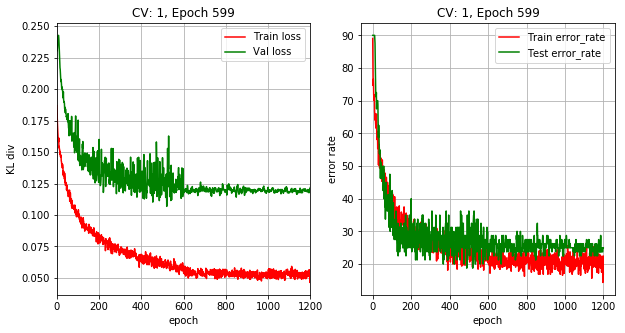

In [26]:
tr_loss = np.array(global_train_loss).mean(axis=0)
vl_loss = np.array(global_val_loss).mean(axis=0)
tr_error = np.array(global_train_error).mean(axis=0)
vl_error = np.array(global_val_error).mean(axis=0)

draw_progress(tr_loss, vl_loss, tr_error, vl_error,  600, 599, 1)